In [5]:
'''
The code takes clips before and after extension and compares their accuracy.
The code also calculates the confusion matrix based on before/after predictions
It also saves the before/after predictions that forms the basis for feedback to RCNN
'''

from __future__ import division
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [53]:
model_path = 'models/PHOCNet_Nov13.pt' # path of the phoc model to use
# the set of maps the code will be run on
A = ['D0042-1070001','D0042-1070002','D0042-1070006','D0042-1070007','D0117-5755018','D0117-5755035','D0117-5755036']

word_filter_len = 1 # only words above this length are considered valid
max_var_len = 1

In [54]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [55]:
model_ = torch.load(model_path)
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [56]:
from strlocale import BasicLocale

def clean_words(words):
    lc = BasicLocale()
    for i, w in enumerate(words):
        try:
            words[i] = lc.represent(w).encode('ascii',errors='ignore')
        except:
            words[i] = w
    return words

# load before, after images and words, transforms and cleans them
# the function also assumes that ground truth words are the same before and after
# returns before_images, after_images, words
def load_and_transform(map_name):
    images_before = np.load('../detection_outputs_ready_for_test/ray_regions_normal_before/'+map_name+'.npy')
    words_before = np.load('../detection_outputs_ready_for_test/ray_labels_normal_before/'+map_name+'.npy')
    words_before = clean_words(words_before)
    images_before, words_before = clean_word_images(images_before, words_before)
    images_before = np.transpose(images_before, (0,3,1,2))
    
    images_after = np.load('../detection_outputs_ready_for_test/ray_regions_normal_after/'+map_name+'.npy')
    words_after = np.load('../detection_outputs_ready_for_test/ray_labels_normal_after/'+map_name+'.npy')
    words_after = clean_words(words_after)
    images_after, words_after = clean_word_images(images_after, words_after)
    images_after = np.transpose(images_after, (0,3,1,2))
    
    print 'Images Before Shape ', images_before.shape
    print 'Words Before Shape ', words_before.shape
    print 'Images After Shape ', images_after.shape
    print 'Words After Shape ', words_after.shape
    return images_before, images_after, words_after

def clean_word_images(images, words):
    selected_idx = [x for x in range(len(words)) if len(words[x]) > word_filter_len]
    images = images[selected_idx]
    words = words[selected_idx]
    return images, words

In [57]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(cnn, images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

In [58]:
def insert_dict_set(dct, key, val):
    if key not in dct:
        dct[key] = set()
    dct[key].add(val)
    
# the method defines the rules to handle multiple dir associated with a given word
# returns conf_words which is a set of word_var where this confusion exists
# word_var: dictionary from word -> chosen_dir. Incase a word has multiple dir
# the following preference order is followed 0 > (1,-1) > (2,-2) > (3,-3) ...
def handle_word_conf(comp_word_var):
    word_var = {}
    conf_words = set()
    for var in comp_word_var.keys():
        dirs = np.array(list(comp_word_var[var]))
        if(len(dirs) == 1):
            word_var[var] = dirs[0]
        else:
            conf_words.add(var)
            idx = np.argmin(np.abs(dirs))
            word_var[var] = dirs[idx]
    return word_var, conf_words

# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
# enable_conf: boolean flag that controls if the confusion logic should be used.
# when enabled if a word is a root word as well as a word variation (happens if root words ar rand and grand)
# it marks it as to be extended and also stores it in the confusion list
def create_word_variations(words, enable_conf=False):
    word_var = {}
    root_word_var = {}
    # create the root word variation dict and set word_var as -1 or +1
    for w in words:
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            for l in range(1,max_var_len+1):
                if len(w) <= l:
                    continue
                insert_dict_set(word_var, var, 0)
                insert_dict_set(word_var, var[l:], l)
                insert_dict_set(word_var, var[:-l], -l)
                var_set.add(var)
                var_set.add(var[l:])
                var_set.add(var[:-l])
        root_word_var[w] = var_set
    word_var, conf_words = handle_word_conf(word_var)
    return word_var, root_word_var, conf_words

In [59]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var, conf_words = create_word_variations(word_strings, enable_conf=True)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var, conf_words)

In [60]:
from scipy.spatial.distance import cdist, pdist, squareform

# gets the actual distances of all the ground truth word variations
def get_all_dist_gt(dist_mat, emb_info, words):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    all_dist = []
    for i in range(len(words)):
        w_dist = []
        w_vars = root_word_var[words[i]]
        for j in range(len(word_var_strings)):
            if word_var_strings[j] in w_vars:
                w_dist.append((word_var_strings[j], dist_mat[i][j]))
        all_dist.append(w_dist)
    return all_dist

# the new report matches method that handles variations
def report_matches_with_variations(dist_mat, word_strings, emb_info, k):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    gt_words_dist = get_all_dist_gt(dist_mat, emb_info, word_strings)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    actual_dist = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            actual_dist.append(dist_mat[i][j])
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    is_correct = []
    for i in range(len(word_strings)):
        is_correct.append(0)
        if word_strings[i].lower() in [mw.lower() for mw in matched_words[i]]:
            is_correct[i] = 1
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    is_correct[i] = 2
                    count = count+1
                    break
    return (count, matched_words, img_dir, words_len, actual_dist, is_correct, gt_words_dist)

# For some images, the original predicted word os both a root word and a word_variation of another word 
# (common word problem). Due to this one cannot be sure, if these images should be extended or not.
# These images are handled by comparing distances before and after image extension and picking the minimum one
# the feature can be turned of by setting enable_conf = False
def update_dist_matrix(dist_mat_before, dist_mat_after, conf_idx):
    print('conf_idx', conf_idx)
    for i in conf_idx:
        dist = np.minimum(dist_mat_before[i], dist_mat_after[i])
        dist_mat_after[i] = dist

In [61]:
def generate_confusion_matrix(match_report_before, match_report_after, words):
    status = [0,1,2]
    conf_matrix = [['before/after','incorrect (0)','correct (1)','almost (2)'],
                   ['incorrect (0)',0,0,0],
                   ['correct (1)',0,0,0],
                   ['almost (2)',0,0,0]]
    for i in status:
        for j in status:
            count = 0
            for k in range(len(words)):
                if match_report_before[5][k] == i and match_report_after[5][k] == j:
                    count += 1
            conf_matrix[1+i][1+j] = count
    return conf_matrix

In [62]:
def save_before_after_preds(map_name, before_report, after_report, ground_truth):
    before_preds = [w[0] for w in before_report[1]]
    after_preds = [w[0] for w in after_report[1]]
    before_after_pred = np.array([before_preds, after_preds, ground_truth]).T
    np.save('../../../before_after_ext_pred/ray_detections/'+map_name+'.npy', before_after_pred)

def compare_images_before_after_ext(map_name, cnn, global_stats):
    images_before, images_after, words = load_and_transform(map_name)
    image_embs_before = get_image_embeddings(cnn, images_before)
    image_embs_after = get_image_embeddings(cnn, images_after)
    word_emb_info = get_word_phoc_representations(words)
    # get the distances between images and words
    dist_matrix_before = cdist(XA=image_embs_before, XB=word_emb_info[0], metric='cosine')
    dist_matrix_after = cdist(XA=image_embs_after, XB=word_emb_info[0], metric='cosine')
    # build the original report
    match_report_before = report_matches_with_variations(dist_matrix_before, words, word_emb_info, 1)
    # get the low confidence image index
    conf_idx = [i for i in range(len(match_report_before[1])) if match_report_before[1][i][0] in word_emb_info[4]]
    # update the dist_after matrix based for low confidence images
    update_dist_matrix(dist_matrix_before, dist_matrix_after, conf_idx)
    # build the report after extension
    match_report_after = report_matches_with_variations(dist_matrix_after, words, word_emb_info, 1)
    # save_before_after_preds(map_name, match_report_before, match_report_after, words)
    global_stats['correct_before'] += match_report_before[0]
    global_stats['correct_after'] += match_report_after[0]
    global_stats['total'] += len(words)
    acc_before = match_report_before[0]/len(words)
    acc_after = match_report_after[0]/len(words)
    conf_matrix = generate_confusion_matrix(match_report_before, match_report_after, words)
    return (acc_before, acc_after, conf_matrix, match_report_before, match_report_after)

In [63]:
global_stats = {'correct_before':0, 'correct_after':0, 'total':0}
local_stats = []
for i in tqdm(range(len(A)), ascii=True, desc='Main Iteration'):
    print A[i]
    stats = compare_images_before_after_ext(A[i], cnn, global_stats)
    local_stats.append(stats)

D0042-1070001
Images Before Shape  (1078, 3, 135, 487)
Words Before Shape  (1078,)
Images After Shape  (1078, 3, 135, 487)
Words After Shape  (1078,)


100%|██████████| 1813/1813 [00:00<00:00, 4349.74it/s]


('embedding variations:', (1813, 945))
('conf_idx', [12, 15, 17, 19, 26, 28, 29, 33, 36, 61, 87, 95, 134, 169, 175, 178, 187, 194, 199, 200, 219, 229, 230, 241, 246, 247, 248, 251, 255, 256, 260, 267, 277, 281, 307, 309, 314, 315, 316, 317, 322, 327, 331, 339, 368, 377, 378, 379, 386, 388, 389, 390, 398, 399, 402, 411, 413, 417, 418, 419, 422, 424, 425, 427, 429, 430, 431, 433, 435, 439, 440, 445, 449, 451, 453, 454, 456, 460, 464, 472, 492, 493, 503, 505, 506, 508, 511, 520, 522, 525, 527, 534, 549, 554, 559, 562, 564, 569, 573, 576, 578, 579, 580, 581, 583, 584, 587, 591, 593, 595, 597, 602, 605, 606, 607, 608, 621, 624, 627, 634, 637, 639, 641, 645, 646, 651, 652, 654, 656, 658, 667, 668, 677, 685, 688, 691, 692, 694, 730, 746, 770, 777, 845, 846, 850, 860, 872, 876, 890, 893, 898, 901, 903, 904, 922, 924, 934, 938, 939, 941, 944, 953, 954, 957, 958, 959, 964, 967, 977, 978, 979, 980, 982, 987, 992, 1010, 1011, 1018, 1019, 1020, 1027, 1042, 1047, 1055, 1059, 1061, 1064, 1067, 1070, 

100%|██████████| 2120/2120 [00:00<00:00, 5063.86it/s]


('embedding variations:', (2120, 945))
('conf_idx', [5, 20, 25, 27, 29, 33, 42, 73, 79, 91, 110, 142, 162, 199, 210, 213, 230, 245, 246, 252, 256, 257, 260, 267, 268, 269, 282, 283, 297, 302, 311, 312, 319, 328, 331, 333, 336, 338, 346, 348, 352, 358, 366, 368, 371, 379, 383, 385, 388, 390, 405, 409, 427, 438, 444, 449, 462, 465, 472, 474, 475, 476, 477, 486, 487, 489, 490, 491, 492, 500, 501, 516, 517, 519, 521, 525, 526, 527, 533, 541, 542, 548, 550, 554, 556, 559, 561, 562, 564, 568, 571, 597, 600, 606, 610, 614, 616, 625, 630, 635, 643, 644, 657, 661, 665, 666, 670, 695, 698, 699, 700, 701, 716, 725, 728, 729, 732, 733, 734, 736, 775, 790, 800, 809, 854, 871, 875, 905, 919, 933, 941, 942, 953, 970, 971, 983, 992, 1001, 1006, 1016, 1022, 1026, 1031, 1034, 1036, 1044, 1049, 1051, 1056, 1058, 1060, 1062, 1066, 1076, 1078, 1080, 1086, 1094, 1097, 1100, 1101, 1102, 1106, 1107, 1109, 1110, 1111, 1113, 1114, 1115, 1119, 1121, 1122, 1123, 1128, 1134, 1138])
D0042-1070006
Images Before Shap

100%|██████████| 2828/2828 [00:00<00:00, 5132.50it/s]


('embedding variations:', (2828, 945))
('conf_idx', [2, 3, 5, 21, 37, 45, 47, 48, 49, 54, 55, 64, 65, 66, 68, 71, 73, 75, 79, 85, 86, 89, 94, 99, 103, 108, 116, 119, 124, 131, 135, 139, 144, 146, 149, 152, 155, 158, 161, 162, 163, 171, 173, 178, 180, 184, 188, 191, 195, 196, 207, 208, 212, 213, 214, 217, 218, 220, 221, 224, 225, 236, 242, 279, 282, 288, 290, 292, 294, 297, 298, 299, 303, 308, 313, 317, 323, 325, 327, 329, 330, 331, 335, 339, 343, 347, 349, 351, 352, 359, 361, 362, 365, 366, 367, 370, 373, 374, 383, 384, 387, 388, 393, 394, 398, 400, 411, 421, 426, 433, 436, 438, 440, 441, 444, 445, 450, 451, 452, 453, 461, 468, 473, 476, 478, 484, 486, 491, 492, 494, 499, 500, 503, 508, 510, 513, 516, 518, 521, 531, 535, 536, 540, 542, 543, 546, 549, 558, 562, 564, 567, 571, 573, 574, 580, 581, 582, 586, 591, 594, 598, 608, 612, 614, 621, 622, 632, 636, 638, 641, 644, 656, 659, 660, 667, 669, 676, 678, 682, 684, 686, 689, 692, 696, 697, 704, 708, 712, 713, 720, 724, 727, 733, 734, 735,

strlocale.py:137: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if c in self._diacrit_dict: # Replace simple diacritic
strlocale.py:152: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return [c if (c not in self.__filtered) else u'' for c in chars]


Images Before Shape  (1302, 3, 135, 487)
Words Before Shape  (1302,)
Images After Shape  (1302, 3, 135, 487)
Words After Shape  (1302,)


100%|██████████| 2037/2037 [00:00<00:00, 4787.92it/s]


('embedding variations:', (2037, 945))
('conf_idx', [3, 4, 5, 7, 8, 14, 16, 18, 19, 21, 24, 25, 26, 27, 28, 30, 32, 35, 36, 37, 38, 41, 43, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 64, 66, 67, 68, 69, 70, 75, 82, 84, 100, 125, 134, 140, 161, 184, 185, 191, 211, 212, 215, 219, 224, 230, 239, 251, 258, 262, 265, 270, 274, 277, 279, 285, 293, 306, 310, 314, 321, 322, 334, 335, 345, 351, 354, 355, 356, 360, 363, 364, 371, 373, 384, 385, 393, 394, 395, 397, 402, 403, 407, 408, 410, 414, 416, 419, 424, 425, 430, 438, 440, 443, 446, 448, 450, 453, 456, 457, 458, 462, 463, 464, 465, 466, 467, 468, 469, 474, 478, 480, 481, 485, 486, 487, 491, 493, 495, 497, 498, 499, 503, 504, 505, 506, 508, 509, 511, 514, 516, 519, 520, 521, 522, 523, 524, 525, 528, 529, 530, 532, 534, 535, 540, 541, 542, 543, 548, 549, 551, 552, 554, 555, 556, 557, 562, 567, 569, 574, 575, 579, 584, 587, 588, 589, 593, 596, 597, 600, 601, 602, 604, 607, 608, 609, 611, 617, 620, 621, 623, 629, 630, 631, 632, 640, 641, 644, 648,

100%|██████████| 5321/5321 [00:01<00:00, 4952.00it/s]


('embedding variations:', (5321, 945))
('conf_idx', [7, 9, 13, 15, 16, 18, 22, 26, 27, 32, 34, 35, 36, 37, 39, 41, 42, 45, 52, 53, 55, 57, 58, 59, 61, 63, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 80, 81, 83, 86, 87, 93, 94, 98, 102, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 119, 122, 123, 124, 125, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 142, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 186, 187, 190, 191, 192, 193, 198, 200, 202, 203, 205, 220, 221, 222, 224, 226, 234, 239, 243, 244, 246, 248, 252, 253, 254, 260, 261, 264, 267, 268, 271, 272, 279, 282, 297, 302, 305, 307, 309, 313, 314, 321, 326, 328, 330, 331, 332, 333, 337, 343, 345, 354, 358, 360, 363, 369, 373, 376, 378, 382, 384, 385, 386, 391, 392, 394, 395, 398, 399, 402, 410, 411, 412, 417, 418, 421, 422, 428, 429, 433, 437, 438, 439, 440, 444, 456, 458, 465, 468, 470

100%|██████████| 3616/3616 [00:00<00:00, 5999.18it/s]


('embedding variations:', (3616, 945))
('conf_idx', [0, 2, 3, 5, 9, 11, 12, 13, 14, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 43, 47, 48, 51, 52, 54, 58, 60, 61, 62, 64, 65, 66, 67, 73, 74, 78, 79, 83, 85, 89, 90, 91, 95, 97, 100, 106, 107, 111, 121, 123, 127, 134, 143, 149, 154, 161, 163, 165, 169, 170, 171, 176, 177, 178, 183, 186, 188, 190, 194, 198, 204, 215, 218, 220, 225, 231, 235, 237, 241, 242, 248, 250, 253, 258, 263, 267, 270, 275, 276, 281, 284, 285, 287, 296, 298, 301, 303, 309, 317, 318, 319, 320, 322, 323, 330, 333, 342, 346, 351, 354, 356, 366, 368, 369, 374, 383, 388, 389, 393, 404, 415, 418, 427, 429, 431, 432, 433, 439, 440, 441, 445, 450, 452, 457, 465, 470, 471, 472, 473, 474, 476, 477, 483, 486, 490, 494, 495, 496, 497, 502, 506, 507, 527, 528, 533, 543, 555, 556, 565, 567, 578, 579, 580, 587, 588, 589, 604, 609, 613, 615, 618, 625, 629, 631, 633, 635, 636, 637, 648, 658, 659, 663, 667, 680, 682, 686, 687, 690, 695, 696, 697, 6

100%|██████████| 4247/4247 [00:00<00:00, 5300.29it/s]


('embedding variations:', (4247, 945))
('conf_idx', [0, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 63, 64, 65, 67, 68, 70, 71, 72, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 117, 118, 122, 129, 130, 133, 135, 138, 145, 146, 149, 154, 161, 166, 168, 176, 178, 179, 180, 188, 195, 204, 211, 221, 227, 239, 240, 262, 273, 276, 284, 286, 290, 293, 296, 306, 308, 311, 313, 314, 316, 322, 325, 331, 338, 351, 354, 357, 362, 365, 374, 388, 401, 405, 406, 414, 420, 421, 422, 429, 434, 437, 438, 446, 448, 449, 451, 455, 457, 468, 475, 476, 481, 490, 494, 495, 506, 521, 523, 526, 534, 536, 538, 542, 545, 552, 553, 556, 557, 559, 574, 578, 579, 583, 586, 593, 596, 603, 608, 612, 613, 619, 625, 631, 639, 642, 646, 657, 658, 664, 670, 677, 692, 697, 702, 706, 717,

In [64]:
# print accuracies
for i in range(len(A)):
    print('Accuracy for image '+A[i])
    print "the accuracy before extension: " + str(local_stats[i][0])
    print "the accuracy after extension: "+str(local_stats[i][1])
    print('\n')
    
print 'Average Accuracy Before ', global_stats['correct_before']/global_stats['total']
print 'Average Accuracy After', global_stats['correct_after']/global_stats['total']

Accuracy for image D0042-1070001
the accuracy before extension: 0.49814471243
the accuracy after extension: 0.507421150278


Accuracy for image D0042-1070002
the accuracy before extension: 0.40825285338
the accuracy after extension: 0.410008779631


Accuracy for image D0042-1070006
the accuracy before extension: 0.351004702864
the accuracy after extension: 0.357417699872


Accuracy for image D0042-1070007
the accuracy before extension: 0.357910906298
the accuracy after extension: 0.37019969278


Accuracy for image D0117-5755018
the accuracy before extension: 0.469294487289
the accuracy after extension: 0.47557840617


Accuracy for image D0117-5755035
the accuracy before extension: 0.479671082686
the accuracy after extension: 0.481955230699


Accuracy for image D0117-5755036
the accuracy before extension: 0.503105590062
the accuracy after extension: 0.510869565217


Average Accuracy Before  0.444491645426
Average Accuracy After 0.450863777967


In [65]:
from IPython.display import HTML, display
def print_conf_matrix(conf_matrix):
    display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in conf_matrix)
        )
    ))

# print the confusion matrix
for i in range(len(A)):
    conf_matrix = local_stats[i][2]
    print('Confusion Matrix for Image ' + A[i])
    print_conf_matrix(conf_matrix)
    print('\n')

Confusion Matrix for Image D0042-1070001




Confusion Matrix for Image D0042-1070002




Confusion Matrix for Image D0042-1070006




Confusion Matrix for Image D0042-1070007




Confusion Matrix for Image D0117-5755018




Confusion Matrix for Image D0117-5755035




Confusion Matrix for Image D0117-5755036


In [67]:
images_before, images_after, words = load_and_transform(A[0])
stats = local_stats[0]
acc_before, acc_after, conf_matrix, match_report_before, match_report_after = stats

Images Before Shape  (1078, 3, 135, 487)
Words Before Shape  (1078,)
Images After Shape  (1078, 3, 135, 487)
Words After Shape  (1078,)


In [68]:
print "Incorrectly classified before and Incorrectly classified after"
import matplotlib.pyplot as plt
ground_truth = match_report_before[1]
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 0 \
    and match_report_after[5][i] == 0:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count
        

Incorrectly classified before and Incorrectly classified after
524


Incorrectly classified before and Correctly classified after
************************************************************************
************************************************************************


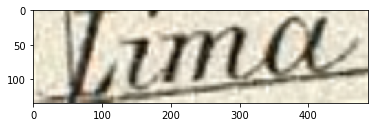

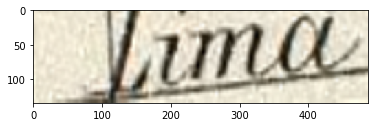

Matched before: $elina$
Matched after:$lima$
Ground truth:Lima
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


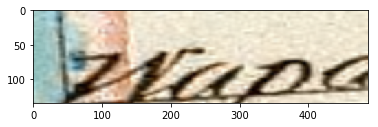

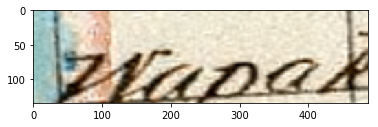

Matched before: $Woo$
Matched after:$Wapakoneta$
Ground truth:Wapakoneta
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


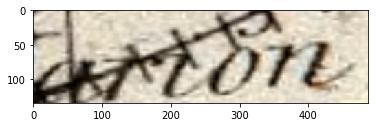

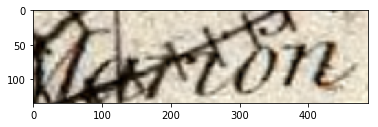

Matched before: $aton$
Matched after:$Marion$
Ground truth:Marion
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


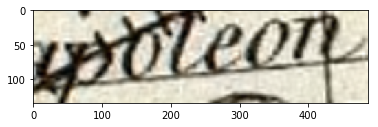

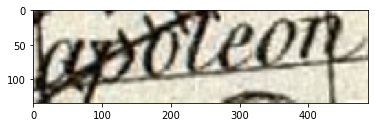

Matched before: $eorgetown$
Matched after:$napoleon$
Ground truth:Napoleon
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


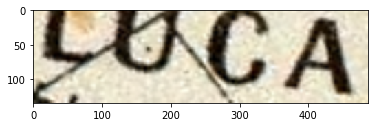

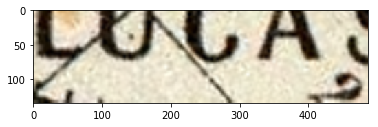

Matched before: $LOGA$
Matched after:$LUCAS$
Ground truth:LUCAS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


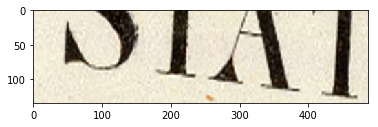

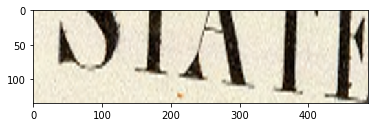

Matched before: $CLAR$
Matched after:$STATE$
Ground truth:STATE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


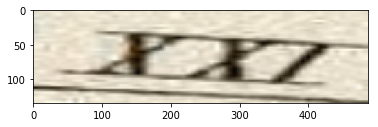

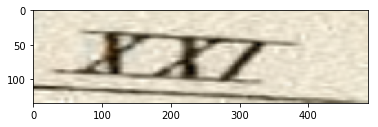

Matched before: $Wer$
Matched after:$XXI$
Ground truth:XXI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


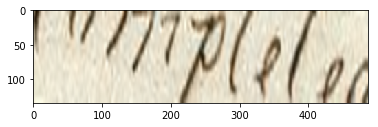

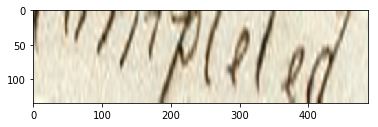

Matched before: $Findla$
Matched after:$completed$
Ground truth:completed
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


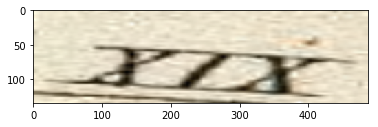

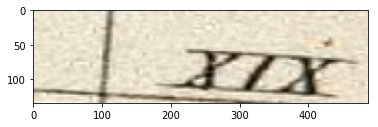

Matched before: $X$
Matched after:$XIX$
Ground truth:XIX
------------------------------------------------------------------------
------------------------------------------------------------------------
9


In [70]:
print "Incorrectly classified before and Correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 0 \
    and match_report_after[5][i] == 1:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(words[i])
        #print "Image Dir before:" + str(match_report_before[2][i])
        #print "Image Dir after:" + str(match_report_after[2][i])
        #print "Distance before:" + str(match_report_before[4][i])
        #print "Distance after:" + str(match_report_after[4][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count   

In [ ]:
print "Incorrectly classified before and Almost correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 0 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Incorrectly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 0:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Correctly classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 1:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Almost classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Almost classified before and In-correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 0:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Image Index: " + str(i)
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "\nAll Distances Before:" + str(match_report_before[6][i])
#         print "\nAll Distances After:" + str(match_report_after[6][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

Almost classified before and Correctly classified after
************************************************************************
************************************************************************


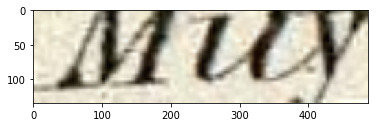

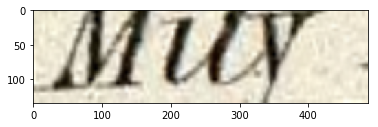

('image index', 43)
Matched before: $MIL$
Matched after:$MILY$
Ground truth:[('MILY', 0.3317451103837431), ('ily', 0.999999999999997), ('mily', 0.9999981819389666), ('Mil', 0.598819240348871), ('Mily', 0.7277996883311795), ('ILY', 0.5254547672793786), ('MIL', 0.29316087585239037), ('mil', 0.9999999987613555)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


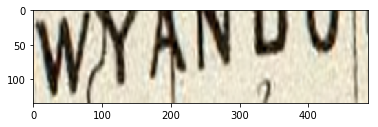

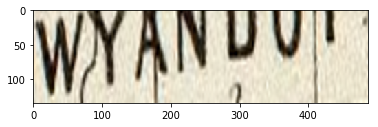

('image index', 56)
Matched before: $WYANDO$
Matched after:$WYANDOT$
Ground truth:[('Wyando', 0.8281264280469061), ('yandot', 0.9999999977746135), ('YANDOT', 0.5260725328212704), ('WYANDOT', 0.28321666937143275), ('wyando', 0.9999999898075038), ('WYANDO', 0.24039560588191466), ('wyandot', 0.9999999901782649), ('Wyandot', 0.8343784819089666)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


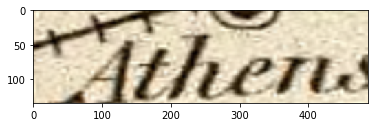

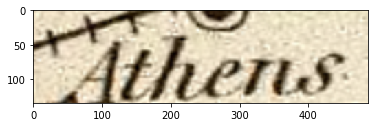

('image index', 57)
Matched before: $Athen$
Matched after:$Athens$
Ground truth:[('THENS', 0.999999999969971), ('thens', 0.47977188884692246), ('Athens', 0.182743108268969), ('ATHEN', 0.8237659501439101), ('athens', 0.3484963492863883), ('ATHENS', 0.8342448367553854), ('Athen', 0.15328076145956593), ('athen', 0.3295127675841809)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


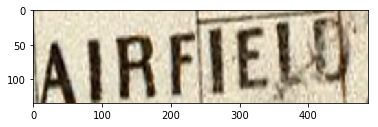

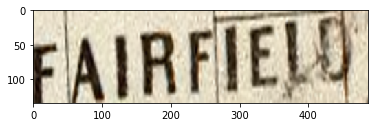

('image index', 63)
Matched before: $AIRFIELD$
Matched after:$FAIRFIELD$
Ground truth:[('Fairfield', 0.9955819170216824), ('fairfield', 0.9999977106675099), ('FAIRFIELD', 0.3832258528914204), ('Fairfiel', 0.9951084688928961), ('fairfiel', 0.9999974921619093), ('airfield', 0.9999999996286529), ('FAIRFIEL', 0.483307319428237), ('AIRFIELD', 0.27790318148752946)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


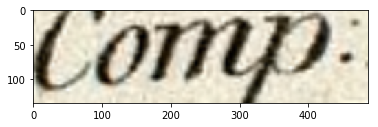

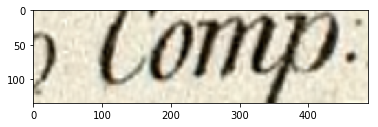

('image index', 71)
Matched before: $omp$
Matched after:$Comp$
Ground truth:[('omp', 0.28257822080997275), ('com', 0.6058715773434138), ('comp', 0.379917994766916), ('COMP', 0.9467413553965043), ('COM', 0.9258320762959585), ('Com', 0.5391462324963794), ('Comp', 0.331880690934957), ('OMP', 0.9999999932397736)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


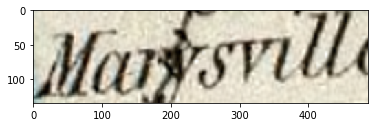

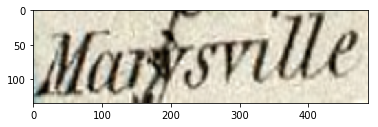

('image index', 73)
Matched before: $Marysvill$
Matched after:$Marysville$
Ground truth:[('Marysvill', 0.14112010592356072), ('marysville', 0.271713916575244), ('Marysville', 0.1522570940117507), ('marysvill', 0.2670386530393051), ('MARYSVILL', 0.8740814528606548), ('ARYSVILLE', 0.9999999937279723), ('MARYSVILLE', 0.8805431713884019), ('arysville', 0.3110087984468347)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


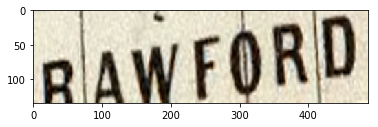

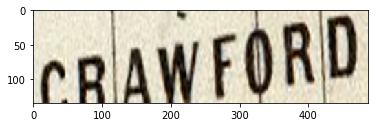

('image index', 90)
Matched before: $RAWFORD$
Matched after:$CRAWFORD$
Ground truth:[('crawfor', 0.9999999999141085), ('CRAWFOR', 0.5076550397146873), ('rawford', 0.9999999995500977), ('Crawford', 0.9999999998337838), ('crawford', 0.999999999796386), ('RAWFORD', 0.2232900335320781), ('CRAWFORD', 0.25989521546262495), ('Crawfor', 0.9999999999541808)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


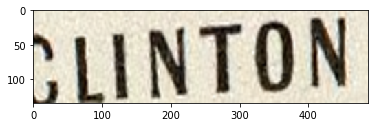

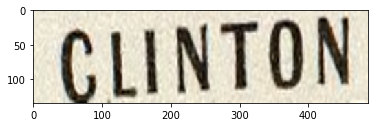

('image index', 117)
Matched before: $LINTON$
Matched after:$CLINTON$
Ground truth:[('Clinton', 0.9999999999999111), ('Clinto', 0.9999999999999093), ('CLINTON', 0.25362289976187236), ('LINTON', 0.019218371233354792), ('CLINTO', 0.4796053329502953), ('clinton', 1.0), ('linton', 0.9999999999999992), ('clinto', 1.0)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


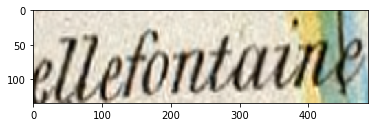

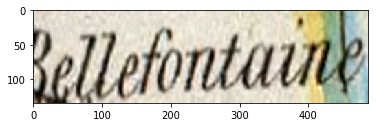

('image index', 127)
Matched before: $ellefontaine$
Matched after:$Bellefontaine$
Ground truth:[('bellefontain', 0.41740107967650864), ('Bellefontaine', 0.25971073168895553), ('ellefontaine', 0.17934532862514307), ('Bellefontain', 0.41740106374517894), ('bellefontaine', 0.259710747114399), ('BELLEFONTAIN', 0.9999999441239863), ('BELLEFONTAINE', 0.9999999458982824), ('ELLEFONTAINE', 0.9999999594128886)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


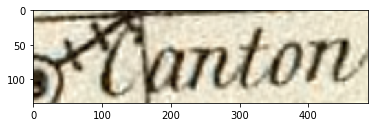

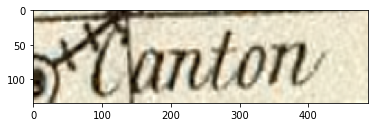

('image index', 130)
Matched before: $canto$
Matched after:$Canton$
Ground truth:[('canto', 0.2310825332547316), ('CANTO', 0.999993300839968), ('ANTON', 0.999999999926953), ('CANTON', 0.9999935743914183), ('canton', 0.23254182602484563), ('Canton', 0.2583923204096982), ('anton', 0.3586382382440132), ('Canto', 0.25803353670344764)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


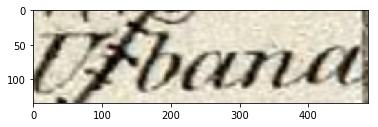

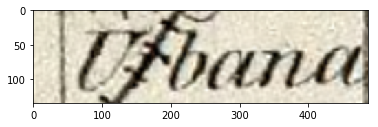

('image index', 142)
Matched before: $rbana$
Matched after:$urbana$
Ground truth:[('Urban', 0.4646482942236977), ('urbana', 0.16697472694800675), ('URBANA', 0.9999962606200764), ('URBAN', 0.9999961812247633), ('urban', 0.4646507257910226), ('Urbana', 0.16697234657730653), ('rbana', 0.10696251945895296), ('RBANA', 0.9999998107366563)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


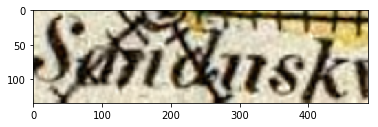

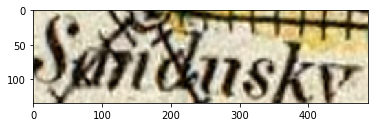

('image index', 172)
Matched before: $Sandusk$
Matched after:$Sandusky$
Ground truth:[('SANDUSK', 0.8560537281139801), ('SANDUSKY', 0.8656612048313412), ('Sandusky', 0.13278632313015148), ('Sandusk', 0.1074208431823126), ('sandusky', 0.2532371623928863), ('andusky', 0.45109832907938086), ('sandusk', 0.2349756575878883), ('ANDUSKY', 0.9646530247904956)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


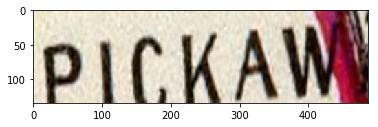

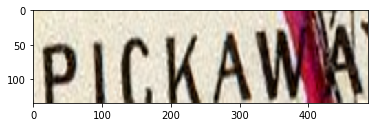

('image index', 173)
Matched before: $PICKAWA$
Matched after:$PICKAWAY$
Ground truth:[('ICKAWAY', 0.4750971314903074), ('Pickawa', 0.8471709234384075), ('PICKAWAY', 0.18199290099224763), ('PICKAWA', 0.0831244680332901), ('pickawa', 0.9999999999997956), ('pickaway', 0.9999999999998097), ('Pickaway', 0.857723872615092), ('ickaway', 0.9999999999999991)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


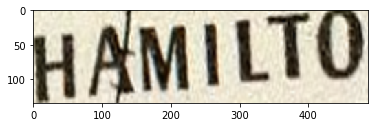

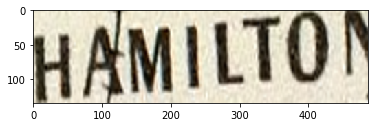

('image index', 208)
Matched before: $HAMILTO$
Matched after:$HAMILTON$
Ground truth:[('amilton', 1.0), ('hamilton', 0.9999999999976145), ('Hamilto', 0.8519109379886223), ('AMILTON', 0.5027356267161104), ('Hamilton', 0.8614753668061761), ('hamilto', 0.9999999999974498), ('HAMILTO', 0.10416737210943838), ('HAMILTON', 0.21345560252225582)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


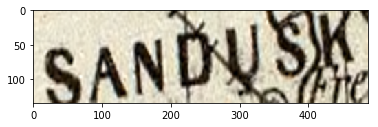

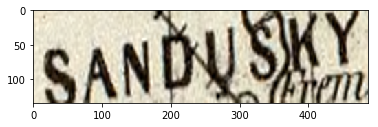

('image index', 210)
Matched before: $SANDUSK$
Matched after:$SANDUSKY$
Ground truth:[('SANDUSK', 0.14760712857344882), ('SANDUSKY', 0.19098863510012642), ('Sandusky', 0.8495807655023364), ('Sandusk', 0.8391950743225529), ('sandusky', 0.999999999334216), ('andusky', 1.0), ('sandusk', 0.9999999992866013), ('ANDUSKY', 0.48054964040328996)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


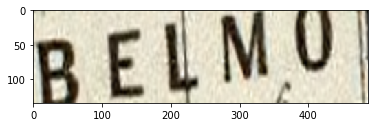

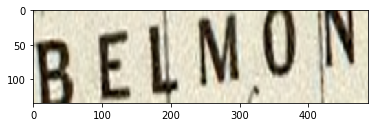

('image index', 216)
Matched before: $BELMON$
Matched after:$BELMONT$
Ground truth:[('BELMON', 0.1709296783176949), ('elmont', 0.9999999999972157), ('BELMONT', 0.37888793044339464), ('Belmon', 0.8124548913031991), ('Belmont', 0.8192770112359737), ('belmont', 0.9999999432375511), ('belmon', 0.999999941094823), ('ELMONT', 0.6171331689249699)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


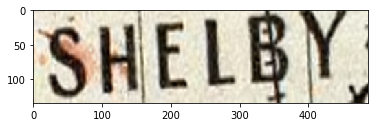

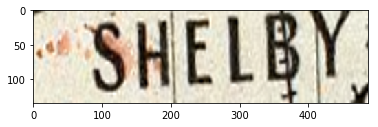

('image index', 222)
Matched before: $HELBY$
Matched after:$SHELBY$
Ground truth:[('helby', 0.9999999999999485), ('Shelby', 0.8439500256582264), ('HELBY', 0.2198599047094948), ('shelby', 0.9999999999475278), ('SHELBY', 0.2243685876792958), ('SHELB', 0.4807914308342731), ('Shelb', 0.8340846920058026), ('shelb', 0.9999999999412175)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


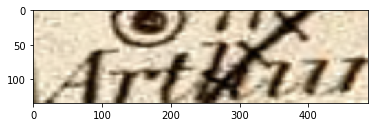

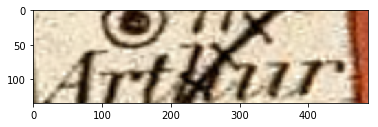

('image index', 226)
Matched before: $Arthu$
Matched after:$Arthur$
Ground truth:[('rthur', 0.651399902655906), ('ARTHU', 0.7805239824725076), ('RTHUR', 0.9999999999994863), ('arthu', 0.5697040207327201), ('Arthur', 0.3548256310596435), ('Arthu', 0.3502281207001805), ('ARTHUR', 0.7894861119077969), ('arthur', 0.5653395190563402)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


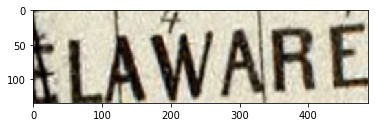

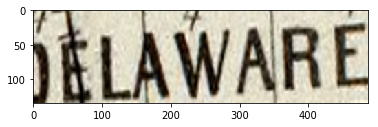

('image index', 236)
Matched before: $ELAWARE$
Matched after:$DELAWARE$
Ground truth:[('delaware', 0.9999999999897664), ('elaware', 0.9999999999999998), ('DELAWAR', 0.5872796228816652), ('Delaware', 0.9999999999568778), ('DELAWARE', 0.4275129781226845), ('Delawar', 0.9999999999545452), ('delawar', 0.9999999999892129), ('ELAWARE', 0.23072199706370944)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


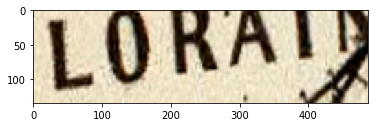

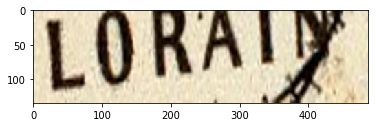

('image index', 330)
Matched before: $LORAI$
Matched after:$LORAIN$
Ground truth:[('orain', 0.9999999999977875), ('LORAIN', 0.3020350744550804), ('lorain', 0.9999999991458688), ('LORAI', 0.28292463830489323), ('lorai', 0.9999999990918653), ('Lorain', 0.8155410350055357), ('Lorai', 0.8038797114969879), ('ORAIN', 0.5501860328599586)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


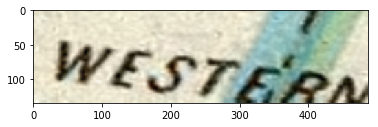

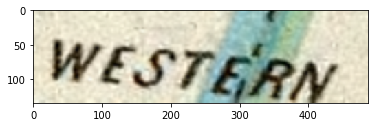

('image index', 376)
Matched before: $WESTER$
Matched after:$WESTERN$
Ground truth:[('Western', 0.7752419594411213), ('WESTERN', 0.48870975830221364), ('ESTERN', 0.791988175236295), ('western', 0.991892790637444), ('estern', 0.9995278739330047), ('wester', 0.9915758907272769), ('WESTER', 0.4529107018780607), ('Wester', 0.7664257424468415)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


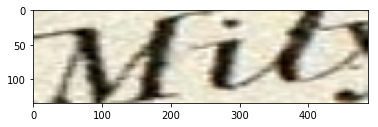

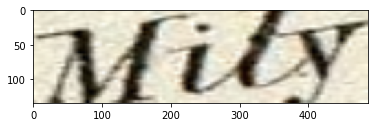

('image index', 469)
Matched before: $Mil$
Matched after:$MILY$
Ground truth:[('MILY', 0.7629795238529924), ('ily', 0.7487158137218289), ('mily', 0.5499989989838607), ('Mil', 0.17478791846733777), ('Mily', 0.3129785229783707), ('ILY', 0.9999999999999508), ('MIL', 0.6468106776735922), ('mil', 0.5279772406113014)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


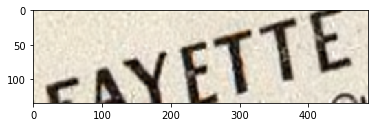

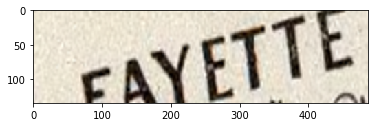

('image index', 486)
Matched before: $AYETTE$
Matched after:$FAYETTE$
Ground truth:[('ayette', 0.9999999999995378), ('fayett', 0.9999999999723479), ('Fayette', 0.9999565801847677), ('Fayett', 0.9999547317133425), ('fayette', 0.9999999999734765), ('FAYETTE', 0.4475999548767401), ('FAYETT', 0.6930688395081288), ('AYETTE', 0.4360701515473181)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


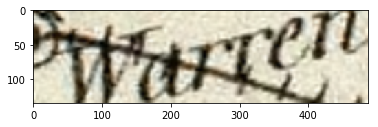

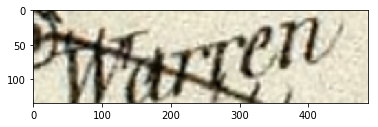

('image index', 487)
Matched before: $Warre$
Matched after:$Warren$
Ground truth:[('WARREN', 0.8170642705331252), ('Warre', 0.32497016448824234), ('warre', 0.512260599983143), ('Warren', 0.36060329441186234), ('arren', 0.4879674110605233), ('WARRE', 0.7954716387780715), ('warren', 0.5281209525327172), ('ARREN', 0.9999999282531912)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


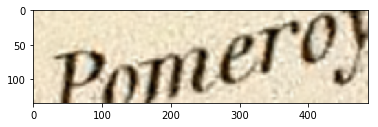

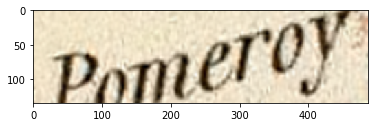

('image index', 513)
Matched before: $Pomero$
Matched after:$Pomeroy$
Ground truth:[('Pomeroy', 0.32904096410582195), ('POMERO', 0.8295051703446277), ('omeroy', 0.557147018336758), ('pomero', 0.3457733530076761), ('POMEROY', 0.8359412737178462), ('pomeroy', 0.49280822129205804), ('Pomero', 0.17558142697001977), ('OMEROY', 0.99999999997528)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


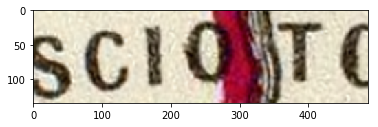

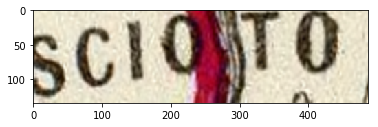

('image index', 575)
Matched before: $SCIOT$
Matched after:$SCIOTO$
Ground truth:[('CIOTO', 0.4166659108428006), ('SCIOTO', 0.32161642002689905), ('Sciot', 0.8178168479302361), ('sciot', 0.9999999980815844), ('scioto', 0.9999999981219766), ('cioto', 0.9999999999792689), ('SCIOT', 0.31691745291021556), ('Scioto', 0.8216527123073591)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


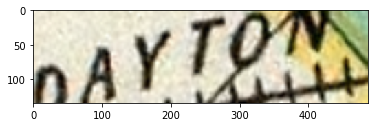

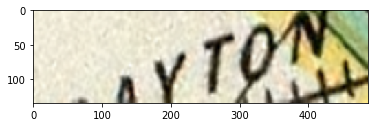

('image index', 619)
Matched before: $AYTON$
Matched after:$DAYTON$
Ground truth:[('dayto', 0.9999999999553617), ('ayton', 0.9999999999999954), ('DAYTON', 0.29643672772732976), ('dayton', 0.9999999999580159), ('AYTON', 0.11876364384624982), ('DAYTO', 0.633104828257141), ('Dayto', 0.9998536014663294), ('Dayton', 0.9998623063314677)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


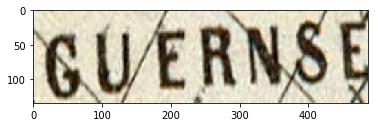

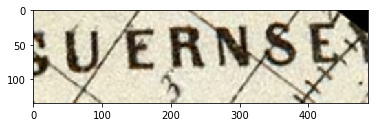

('image index', 679)
Matched before: $GUERNSE$
Matched after:$GUERNSEY$
Ground truth:[('GUERNSE', 0.07990761378743261), ('Guernse', 0.9985199498021892), ('UERNSEY', 0.4758503057397325), ('uernsey', 0.9999999999999996), ('guernsey', 0.9999999921296483), ('GUERNSEY', 0.29377649540319395), ('Guernsey', 0.9986187334951846), ('guernse', 0.9999999915667863)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


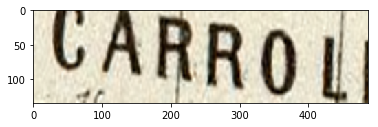

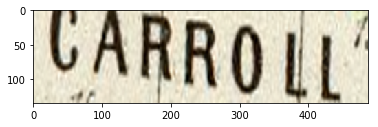

('image index', 706)
Matched before: $CARROL$
Matched after:$CARROLL$
Ground truth:[('Carroll', 0.819389506209571), ('CARROL', 0.02497312715402855), ('carroll', 1.0), ('CARROLL', 0.18170828589998955), ('arroll', 1.0), ('carrol', 1.0), ('Carrol', 0.830572338707176), ('ARROLL', 0.43974282954819033)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


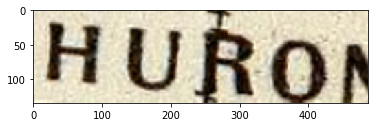

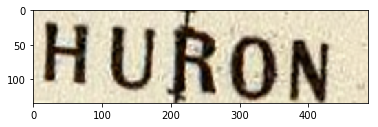

('image index', 709)
Matched before: $HURO$
Matched after:$HURON$
Ground truth:[('huro', 0.9999999997689226), ('HURO', 0.078600011659678), ('Huro', 0.7923774260893823), ('Huron', 0.8071833736504843), ('huron', 0.9999999997845193), ('URON', 0.66174571571479), ('uron', 1.0), ('HURON', 0.2507549489782279)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


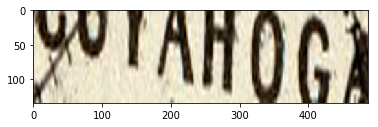

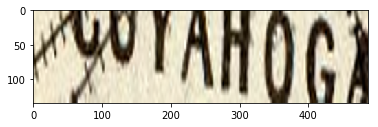

('image index', 733)
Matched before: $UYAHOGA$
Matched after:$CUYAHOGA$
Ground truth:[('Cuyahoga', 0.9999987101475355), ('cuyahog', 0.9999999902114001), ('CUYAHOG', 0.43132191213049453), ('uyahoga', 0.9999999999992302), ('UYAHOGA', 0.1641690676233456), ('cuyahoga', 0.9999999906970916), ('CUYAHOGA', 0.24766144310571747), ('Cuyahog', 0.9999986428061935)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


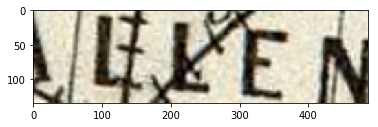

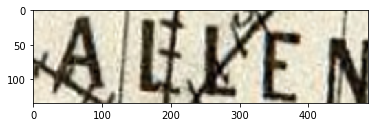

('image index', 744)
Matched before: $LLEN$
Matched after:$ALLEN$
Ground truth:[('LLEN', 0.2718946841574289), ('ALLE', 0.6747877101018104), ('allen', 0.9999999999954096), ('Allen', 0.9999991574465875), ('ALLEN', 0.3366993087933794), ('alle', 0.9999999999952902), ('llen', 0.9999999418130169), ('Alle', 0.9999991354018237)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


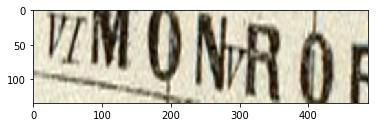

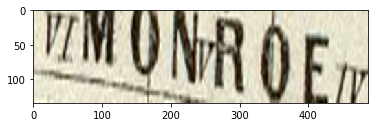

('image index', 753)
Matched before: $MONRO$
Matched after:$MONROE$
Ground truth:[('Monroe', 0.8851235063923073), ('monro', 0.9999999778949542), ('ONROE', 0.5415675824946077), ('MONROE', 0.31464750593456736), ('MONRO', 0.2792344654846237), ('monroe', 0.9999999792636289), ('onroe', 0.9999999999999946), ('Monro', 0.877541246352096)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


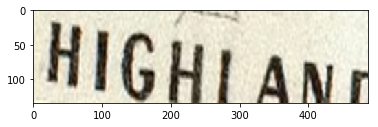

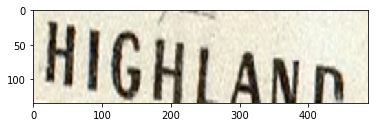

('image index', 772)
Matched before: $HIGHLAN$
Matched after:$HIGHLAND$
Ground truth:[('Highlan', 0.8473825560195902), ('ighland', 0.9999999999857094), ('highlan', 0.9999999993826656), ('HIGHLAND', 0.13058914551511092), ('HIGHLAN', 0.1044756736887823), ('highland', 0.9999999994252929), ('IGHLAND', 0.42753139941683804), ('Highland', 0.8572394533450354)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


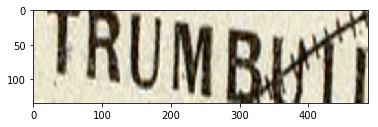

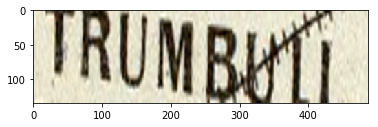

('image index', 807)
Matched before: $TRUMBUL$
Matched after:$TRUMBULL$
Ground truth:[('TRUMBUL', 0.2909735106106526), ('trumbul', 0.9999998390484288), ('Trumbul', 0.9981392643465018), ('rumbull', 0.9999999999788555), ('trumbull', 0.9999998419486946), ('Trumbull', 0.9981727938613302), ('RUMBULL', 0.5485487197316083), ('TRUMBULL', 0.2928048977062465)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


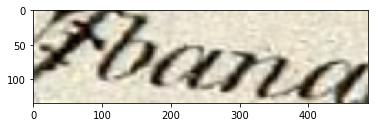

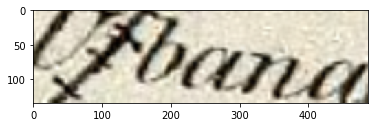

('image index', 809)
Matched before: $rbana$
Matched after:$Urbana$
Ground truth:[('Urban', 0.72503710668533), ('urbana', 0.4764639324627904), ('URBANA', 0.9996569329750659), ('URBAN', 0.9996495805455337), ('urban', 0.7197879108742136), ('Urbana', 0.4816026065105513), ('rbana', 0.4228597018382191), ('RBANA', 0.9999649669576929)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


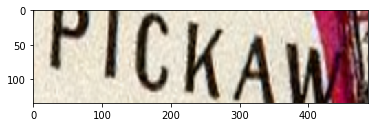

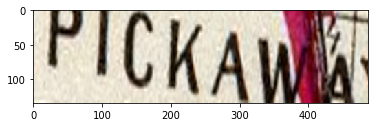

('image index', 819)
Matched before: $PICKAWA$
Matched after:$PICKAWAY$
Ground truth:[('ICKAWAY', 0.49916044601132514), ('Pickawa', 0.8541158697372653), ('PICKAWAY', 0.21939611786966406), ('PICKAWA', 0.12580257481086865), ('pickawa', 0.9999999999984684), ('pickaway', 0.9999999999985741), ('Pickaway', 0.8641892657623144), ('ickaway', 0.9999999999999716)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


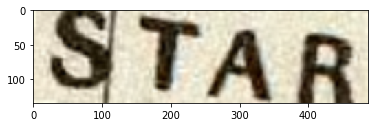

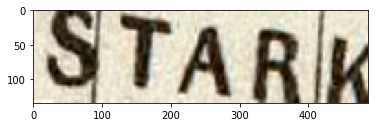

('image index', 831)
Matched before: $STAR$
Matched after:$STARK$
Ground truth:[('Star', 0.7828811102046465), ('TARK', 0.7287479165499972), ('stark', 0.9999999999979133), ('STARK', 0.3415143479760575), ('Stark', 0.7976517986193211), ('tark', 0.9999999999998677), ('STAR', 0.07695464882410585), ('star', 0.9999999999977623)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


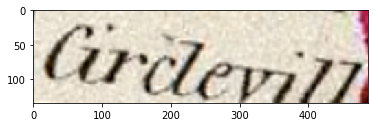

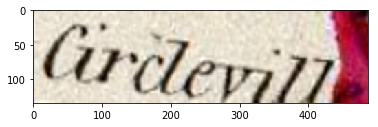

('image index', 835)
Matched before: $Circlevill$
Matched after:$Circleville$
Ground truth:[('IRCLEVILLE', 0.9792607927753252), ('circlevill', 0.17534203050238273), ('CIRCLEVILLE', 0.9608339384514188), ('CIRCLEVILL', 0.9619071853815861), ('Circleville', 0.1713642775839218), ('ircleville', 0.2583477667405546), ('Circlevill', 0.15970208193325863), ('circleville', 0.18714177619721928)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


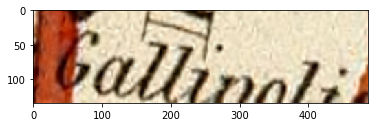

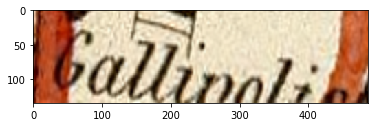

('image index', 836)
Matched before: $Gallipoli$
Matched after:$Gallipolis$
Ground truth:[('ALLIPOLIS', 0.999995985139565), ('allipolis', 0.4585471700018776), ('GALLIPOLIS', 0.9994295170537754), ('GALLIPOLI', 0.9993910926491788), ('Gallipolis', 0.3588075120648375), ('gallipoli', 0.31740406090169127), ('Gallipoli', 0.3168537336695414), ('gallipolis', 0.3593203571235337)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


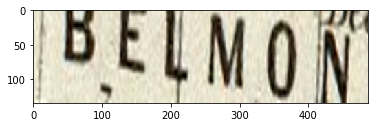

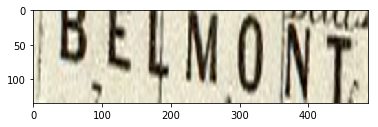

('image index', 873)
Matched before: $BELMON$
Matched after:$BELMONT$
Ground truth:[('BELMON', 0.0023441298799048438), ('elmont', 1.0), ('BELMONT', 0.29656281897292347), ('Belmon', 0.8434002068727908), ('Belmont', 0.8490966634617423), ('belmont', 0.9999999984746184), ('belmon', 0.9999999984170367), ('ELMONT', 0.543034310617495)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


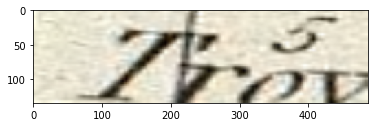

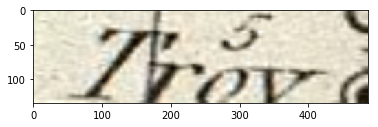

('image index', 889)
Matched before: $Tro$
Matched after:$Troy$
Ground truth:[('Tro', 0.373362719519739), ('TROY', 0.9323888827686457), ('roy', 0.6187565966049214), ('troy', 0.6420104945853131), ('Troy', 0.5744638097192378), ('TRO', 0.8992550332536408), ('tro', 0.47402139371785024), ('ROY', 0.999911866789295)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


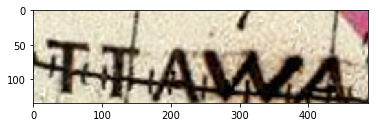

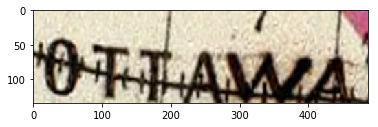

('image index', 892)
Matched before: $TTAWA$
Matched after:$OTTAWA$
Ground truth:[('OTTAW', 0.7455716500716882), ('ottawa', 0.9999999645367792), ('Ottaw', 0.9999996156190206), ('ottaw', 0.999999995206212), ('Ottawa', 0.9999996026145929), ('TTAWA', 0.3381545811114304), ('ttawa', 0.9999881908851019), ('OTTAWA', 0.49804500182282196)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


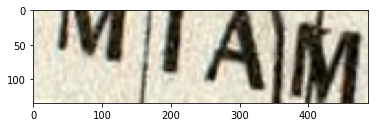

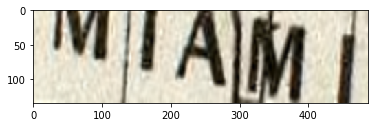

('image index', 895)
Matched before: $MIAM$
Matched after:$MIAMI$
Ground truth:[('MIAM', 0.09997826722112169), ('MIAMI', 0.33608065579483126), ('iami', 0.9999999792028348), ('miam', 0.9999999841306562), ('IAMI', 0.7361042003560418), ('Miam', 0.6954052378409528), ('Miami', 0.7666252048838733), ('miami', 0.9999999859933985)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


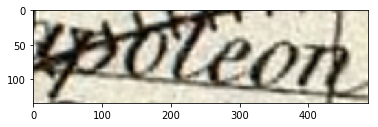

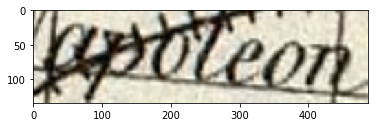

('image index', 909)
Matched before: $apoleon$
Matched after:$napoleon$
Ground truth:[('Napoleo', 0.7046706208118034), ('Napoleon', 0.4001432993418047), ('NAPOLEO', 0.9946992414614076), ('NAPOLEON', 0.9949712589063459), ('napoleo', 0.654730529082342), ('APOLEON', 0.991229008608566), ('napoleon', 0.3902213005411127), ('apoleon', 0.3426075289481674)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


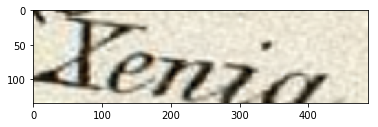

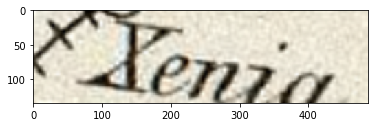

('image index', 913)
Matched before: $enia$
Matched after:$Xenia$
Ground truth:[('XENI', 0.9996384511430617), ('enia', 0.18772557307184912), ('xenia', 0.2153430688045368), ('ENIA', 0.9999999893680217), ('xeni', 0.610702921696935), ('XENIA', 0.9996628481584459), ('Xenia', 0.2150081125544705), ('Xeni', 0.6103443306225879)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


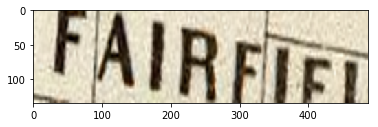

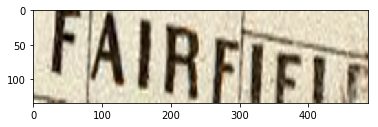

('image index', 965)
Matched before: $FAIRFIEL$
Matched after:$FAIRFIELD$
Ground truth:[('Fairfield', 0.8779120444895747), ('fairfield', 0.9999999983822526), ('FAIRFIELD', 0.26491536122866743), ('Fairfiel', 0.8648289235143238), ('fairfiel', 0.9999999982278466), ('airfield', 1.0), ('FAIRFIEL', 0.21345595190373357), ('AIRFIELD', 0.4877203555413734)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


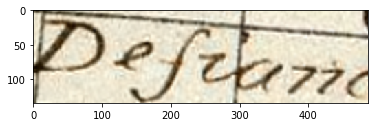

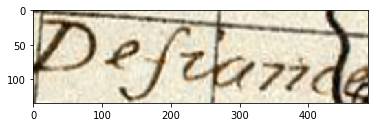

('image index', 971)
Matched before: $Defianc$
Matched after:$Defiance$
Ground truth:[('defiance', 0.6635124793278211), ('Defiance', 0.45791329807407977), ('EFIANCE', 0.999999513073258), ('DEFIANC', 0.7815263682672497), ('Defianc', 0.4319110605535572), ('efiance', 0.7530321028724234), ('defianc', 0.648244279330457), ('DEFIANCE', 0.7923666936958889)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


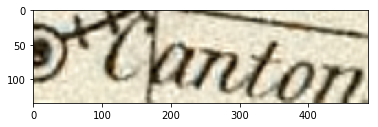

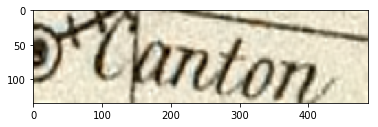

('image index', 993)
Matched before: $canto$
Matched after:$canton$
Ground truth:[('canto', 0.23439178245719883), ('CANTO', 0.9993470443857164), ('ANTON', 0.9999985492421882), ('CANTON', 0.9993737024901045), ('canton', 0.28262676433988154), ('Canton', 0.31369003816876184), ('anton', 0.40448493098870586), ('Canto', 0.266777484162816)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


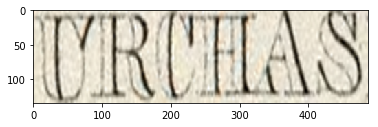

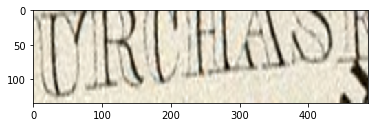

('image index', 997)
Matched before: $PURCHAS$
Matched after:$PURCHASE$
Ground truth:[('urchase', 0.999999999999622), ('purchase', 0.9999989617537443), ('Purchase', 0.9999973273380264), ('URCHASE', 0.4302973391724656), ('PURCHASE', 0.34260041275814734), ('Purchas', 0.999997142804167), ('PURCHAS', 0.27455587832239636), ('purchas', 0.9999988900680652)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


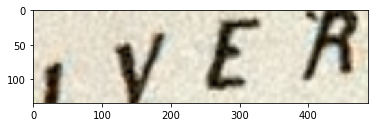

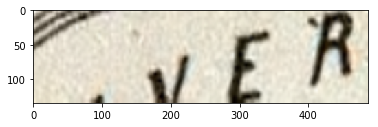

('image index', 1015)
Matched before: $IVER$
Matched after:$RIVER$
Ground truth:[('RIVE', 0.7551179276278844), ('IVER', 0.3142910962512815), ('iver', 0.9999999999999989), ('RIVER', 0.35328302556868063), ('rive', 1.0), ('river', 1.0), ('River', 0.9409315739639692), ('Rive', 0.9366561700121457)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


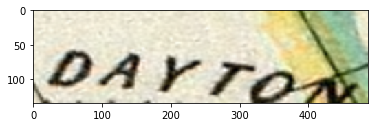

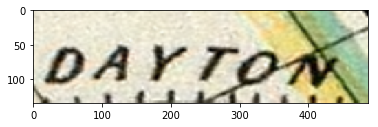

('image index', 1054)
Matched before: $DAYTO$
Matched after:$DAYTON$
Ground truth:[('dayto', 0.9999997905930557), ('ayton', 0.9999999929913451), ('DAYTON', 0.415435475403904), ('dayton', 0.9999998088908046), ('AYTON', 0.5118263895564441), ('DAYTO', 0.29059738818006065), ('Dayto', 0.8692079801009082), ('Dayton', 0.876984886889179)]
------------------------------------------------------------------------
------------------------------------------------------------------------
52


In [74]:
print "Almost classified before and Correctly classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 1:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print('image index', i)
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(ground_truth[i])
        # print "Image Dir before:" + str(match_report_before[3][i])
        # print "Image Dir after:" + str(match_report_after[3][i])
        # print "Distance before:" + str(match_report_before[7][i])
        # print "Distance after:" + str(match_report_after[7][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Almost classified before and Almost classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[qualified_ids[i]],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(ground_truth[i])
#         print "Image Dir before:" + str(match_report_before[3][i])
#         print "Image Dir after:" + str(match_report_after[3][i])
#         print "Distance before:" + str(match_report_before[7][i])
#         print "Distance after:" + str(match_report_after[7][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count